# ERA5 precipitation climatology

* Produce the PDFs of ERA5 hourly precipitation on CONUS grid cells

In [1]:
import os
import sys
import time
import numpy as np
from glob import glob
from datetime import datetime, timedelta
from scipy.interpolate import RegularGridInterpolator

import h5py
import netCDF4 as nc

In [2]:
sys.path.insert(0, '/glade/u/home/ksha/GAN_proj/')
sys.path.insert(0, '/glade/u/home/ksha/GAN_proj/libs/')

from namelist import *
import data_utils as du

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
with h5py.File(save_dir+'CNN_domain.hdf', 'r') as h5io:
    lon_01 = h5io['lon_01'][...]
    lat_01 = h5io['lat_01'][...]
    lon_GFS = h5io['lon_GFS'][...]
    lat_GFS = h5io['lat_GFS'][...]

In [5]:
ERA5_dir = '/glade/campaign/cisl/aiml/ksha/ERA5/ERA5_APCP_2018_2023.nc'

In [6]:
lat_lim = [158, 262]
lon_lim = [218, 459]
grid_shape = lon_GFS.shape

In [7]:
with nc.Dataset(ERA5_dir, 'r') as ncio:
    ERA5_x = ncio['longitude'][...]
    ERA5_y = ncio['latitude'][...]

ERA5_lon, ERA5_lat = np.meshgrid(ERA5_x, ERA5_y)

In [8]:
q_bins = np.arange(0, 1, 0.01)
N_bins = len(q_bins)
# q_ERA5 = np.load('/glade/campaign/cisl/aiml/ksha/ERA5/ERA5_APCP_quantile.npy')
N_hour = 24*(365+365+366+365+365)

## Compute quantile by per grid cells

In [9]:
# name_save = '/glade/campaign/cisl/aiml/ksha/ERA5/ERA5_APCP_quantile_i{}_j{}.npy'
# for i, ix in enumerate(range(lat_lim[0], lat_lim[1]+1, 1)):
#     for j, iy in enumerate(range(lon_lim[0], lon_lim[1]+1, 1)):
#         q_ERA5_ = q_ERA5[:, i, j]
#         if np.sum(np.isnan(q_ERA5_)) == 0:
#             print(name_save.format(i, j))
#             np.save(name_save.format(i, j), q_ERA5_)

In [10]:
i_start = 0
i_end = 105

In [11]:
name_save = '/glade/campaign/cisl/aiml/ksha/ERA5/ERA5_APCP_quantile_i{}_j{}.npy'
# with nc.Dataset(ERA5_dir, 'r') as ncio:
#     for i, ix in enumerate(range(lat_lim[0], lat_lim[1]+1, 1)):
#         for j, iy in enumerate(range(lon_lim[0], lon_lim[1]+1, 1)):
#             name_ = name_save.format(i, j)
#             if os.path.isfile(name_) is False:
#                 if i >= i_start and i < i_end:
#                     # compute quantiles
#                     ERA5_APCP = ncio['tp'][:, 0, ix, iy]
#                     ERA5_APCP = np.array(ERA5_APCP)[:N_hour]*1000
#                     ERA5_APCP[ERA5_APCP<1e-7] = 0.0 # ERA5 zero = 6.93889390e-15
#                     q_ERA5 = np.quantile(ERA5_APCP, q_bins)
#                     # save
#                     print(name_)
#                     np.save(name_, q_ERA5)

## Match ERA5 quantiles with MRMS

In [12]:
from scipy.spatial import cKDTree

In [13]:
q_bins = np.arange(0, 1, 0.01)
N_bins = len(q_bins)

grid_shape = ERA5_lat[lat_lim[0]:(lat_lim[1]+1), lon_lim[0]:(lon_lim[1]+1)].shape
ERA5_CDFs_ = np.empty((N_bins,)+grid_shape); ERA5_CDFs_[...] = np.nan

for i, ix in enumerate(range(lat_lim[0], lat_lim[1]+1, 1)):
    for j, iy in enumerate(range(lon_lim[0], lon_lim[1]+1, 1)):
        name_ = name_save.format(i, j)
        ERA5_q_ = np.load(name_)
        if ERA5_q_.shape == (N_bins,):
            ERA5_CDFs_[:, i, j] = ERA5_q_ #np.cumsum(ERA5_q_)
        else:
            print('Missing: {}'.format(name_))

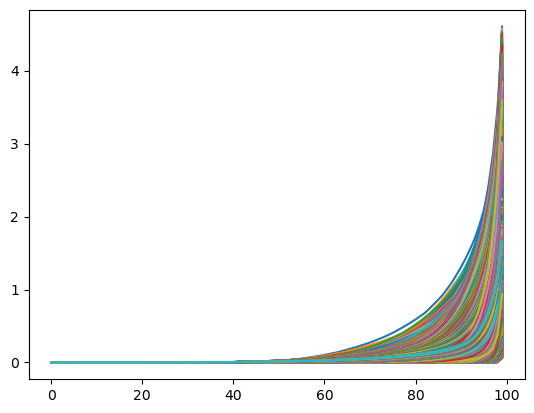

In [19]:
plt.plot(ERA5_CDFs_.reshape(100, 105*242));

**Flip ERA5 lat dimension**

In [20]:
ERA5_CDFs = np.empty((N_bins,)+grid_shape); ERA5_CDFs[...] = np.nan

for i in range(N_bins):
    ERA5_CDFs[i, ...] = np.flipud(ERA5_CDFs_[i, ...])

**Match 0.1 deg MRMS grids with 0.25 deg ERA5 grids**

In [21]:
shape_MRMS = lon_01.shape
shape_ERA5 = lon_GFS.shape

indx_array = np.empty(shape_MRMS)
indy_array = np.empty(shape_MRMS)

gridTree = cKDTree(list(zip(lon_GFS.ravel(), lat_GFS.ravel())))

for xi in range(shape_MRMS[0]):
    for yi in range(shape_MRMS[1]):
        
        temp_lon = lon_01[xi, yi]
        temp_lat = lat_01[xi, yi]
        
        _, indexes = gridTree.query(list(zip(np.array(temp_lon)[None], np.array(temp_lat)[None])))
        indx_in_ERA5, indy_in_ERA5 = np.unravel_index(indexes, shape_ERA5)
        
        indx_array[xi, yi] = indx_in_ERA5[0]
        indy_array[xi, yi] = indy_in_ERA5[0]

In [22]:
indx_array = indx_array.astype(int)
indy_array = indy_array.astype(int)

In [23]:
xi = 50
yi = 75
lon_01[xi, yi]

-117.15000036705996

In [24]:
lon_GFS[indx_array[xi, yi], indy_array[xi, yi]]

-117.25

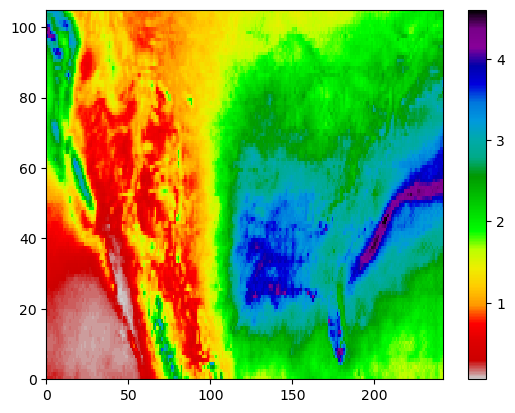

In [27]:
plt.pcolormesh(ERA5_CDFs[-1, ...], cmap=plt.cm.nipy_spectral_r);
plt.colorbar()

## Save

In [29]:
# tuple_save = (lon_GFS, lat_GFS, ERA5_CDFs, indx_array, indy_array)
# label_save = ['lon_GFS', 'lat_GFS', 'ERA5_CDFs', 'indx_in_GFS', 'indy_in_GFS']
# du.save_hdf5(tuple_save, label_save, save_dir, 'ERA5_CDFs.hdf')